# Project 1 - part A

Dataset with the 30 Stocks from S&P500 Index from 2014 to 2024

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("../project1-partA/project1_data.csv")
df_SP500 = pd.read_csv("../project1-partA/sp500_px_open_last.csv")
df = df.dropna() # VRTX has null PX_LAST in 2015-05-12	
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75479 entries, 0 to 75479
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          75479 non-null  object 
 1   PX_LAST       75479 non-null  float64
 2   CUR_MKT_CAP   75479 non-null  float64
 3   PX_VOLUME     75479 non-null  float64
 4   Ticker        75479 non-null  object 
 5   Market_Value  75479 non-null  float64
dtypes: float64(4), object(2)
memory usage: 4.0+ MB


## Daily Return

In [29]:
tickers = df["Ticker"].unique()
all_tickers_df = []

for tik in tickers:
    mask = df["Ticker"]==tik
    last_day_value = df.loc[mask,'PX_LAST'].shift(1)
    today_value = df.loc[mask,'PX_LAST']
    df.loc[mask, 'Daily_Return'] = (today_value - last_day_value) / last_day_value

df.loc[df['Daily_Return'].isna(),"Daily_Return"] = 0


last_day_value = df_SP500.loc[:,'PX Last'].shift(1)
today_value = df_SP500.loc[:,'PX Last']
df_SP500.loc[:,"Daily_Return"] = (today_value - last_day_value) / last_day_value
df_SP500.loc[df_SP500['Daily_Return'].isna(),"Daily_Return"] = 0
df_SP500 = df_SP500[df_SP500["Date"]<="2023-31-31"]

## Value-Weighted and Equally-Weighted Portfolio

In [30]:
n_tickers = len(df["Ticker"].unique())

df['Date'] = pd.to_datetime(df['Date'])

# Group by year and month
grouped = df.groupby([df['Date'].dt.year, df['Date'].dt.month])

# This is a list of dataframes grouped by the month and year of the Date
dfs_by_month_year = [group.reset_index(drop=True) for _, group in grouped]

# Setting the first portfolio weight
equal_weight = 1 / n_tickers 
dfs_by_month_year[0]["Equal_Weight"] = equal_weight

In [31]:
# This is the value that we start with (100%)
cumulative_value_EWP = 1

for i in range(len(dfs_by_month_year)-1):
    # For the value weight calculate all value_Weight, without rebalancing
    df_specific_month_year = dfs_by_month_year[i]
    
    # Calculate the portfolio daily return
    df_specific_month_year["Equal_weight*Daily_Return"] = df_specific_month_year["Equal_Weight"]*df_specific_month_year["Daily_Return"]
    EWP_daily_returns = df_specific_month_year.groupby("Date")["Equal_weight*Daily_Return"].sum().rename("EWP_daily_return")
    df_specific_month_year = df_specific_month_year.drop(columns=["Equal_weight*Daily_Return"])
    
    # Update the cumulative return after this month
    for EWP_daily_return in EWP_daily_returns:
        cumulative_value_EWP*=(1+EWP_daily_return)
        
    # Use the cumulative value at the end of the month and divide it by the number of tickers
    next_month_Equal_weight = cumulative_value_EWP / n_tickers

    df_next_month_year = dfs_by_month_year[i+1]
    df_next_month_year["Equal_Weight"] = next_month_Equal_weight

In [32]:
# Connecting all the dataframes
new_df = pd.concat(dfs_by_month_year)
new_df["Equal_Weight*Daily_Return"] = new_df["Equal_Weight"]*new_df["Daily_Return"]

equal_weighted_return = new_df.groupby("Date")["Equal_Weight*Daily_Return"].sum()

portfolios = pd.DataFrame({
    "Daily_Return_with_Equal_Weighted_Portfolio": equal_weighted_return
})

portfolios.reset_index(inplace=True)
portfolios

,Date,Daily_Return_with_Equal_Weighted_Portfolio
0,2014-01-02,0.000000
1,2014-01-03,0.004006
2,2014-01-06,0.000032
3,2014-01-07,0.007440
4,2014-01-08,0.003497
...,...,...
2511,2023-12-22,0.005197
2512,2023-12-26,0.022738
2513,2023-12-27,-0.003188
2514,2023-12-28,0.001596


## Annualized Average Return

In [33]:
# Compute annualized average return
annualized_df =portfolios.groupby(portfolios['Date'].dt.strftime('%Y'))[["Daily_Return_with_Equal_Weighted_Portfolio"]].mean()*252
annualized_df.reset_index(inplace=True)
annualized_df.rename(columns={"Daily_Return_with_Equal_Weighted_Portfolio":"Average_Annual_Return_with_Equal_Weighted_Portfolio"},inplace=True)

# Compute annualized average return S&P500
annualized_dfSP500 = df_SP500.groupby(portfolios['Date'].dt.strftime('%Y'))["Daily_Return"].mean().rename("Average_Annual_Return")*252

In [34]:
annualized_df

,Date,Average_Annual_Return_with_Equal_Weighted_Portfolio
0,2014,0.239542
1,2015,0.014034
2,2016,0.249644
3,2017,0.334828
4,2018,-0.124841
5,2019,0.552997
6,2020,-0.034457
7,2021,0.955253
8,2022,-0.279740
9,2023,0.573372


## Annualized Standard Deviation

In [35]:
# compute annualized standard deviation return
standard_deviation_return = portfolios.groupby(portfolios['Date'].dt.strftime('%Y'))[["Daily_Return_with_Equal_Weighted_Portfolio"]].std(ddof=0) * np.sqrt(252)
standard_deviation_return = standard_deviation_return.rename(columns={"Daily_Return_with_Equal_Weighted_Portfolio":"Standard_Deviation_with_Equal_Weighted_Portfolio"})
standard_deviation_return

,Standard_Deviation_with_Equal_Weighted_Portfolio
Date,
2014,0.151781
2015,0.215832
2016,0.221749
2017,0.149834
2018,0.407061
2019,0.321539
2020,0.789416
2021,0.496037
2022,0.846607


In [36]:
# CHANGE THIS VALUE FOR A REAL VALUE
risk_free_annual_rate = 0.0559

## Sharpe Ratio and Information Ratio with annualized Average Return

In [37]:
annualized_df["Excess_Return_EWP"] = annualized_df["Average_Annual_Return_with_Equal_Weighted_Portfolio"] - risk_free_annual_rate
risk_premium_EWP = annualized_df["Excess_Return_EWP"].mean()
SD_Excess_Return_EWP = annualized_df["Excess_Return_EWP"].std(ddof=0)
sharpe_ratio_EWP = risk_premium_EWP / SD_Excess_Return_EWP
print(sharpe_ratio_EWP)

0.5416268840455257


## Plot cumulative returns for both porfolios, S&P 500 and risk-free using annualized returns

In [38]:
returns_per_year = pd.DataFrame()
returns_per_year["Date"] = annualized_df["Date"]
returns_per_year["Annually_Return_EWP"] = annualized_df["Average_Annual_Return_with_Equal_Weighted_Portfolio"]
returns_per_year["Annually_Return_with_Risk_Free_Asset"] = risk_free_annual_rate
returns_per_year["Annually_Return_with_SP500"] = annualized_dfSP500.to_list()

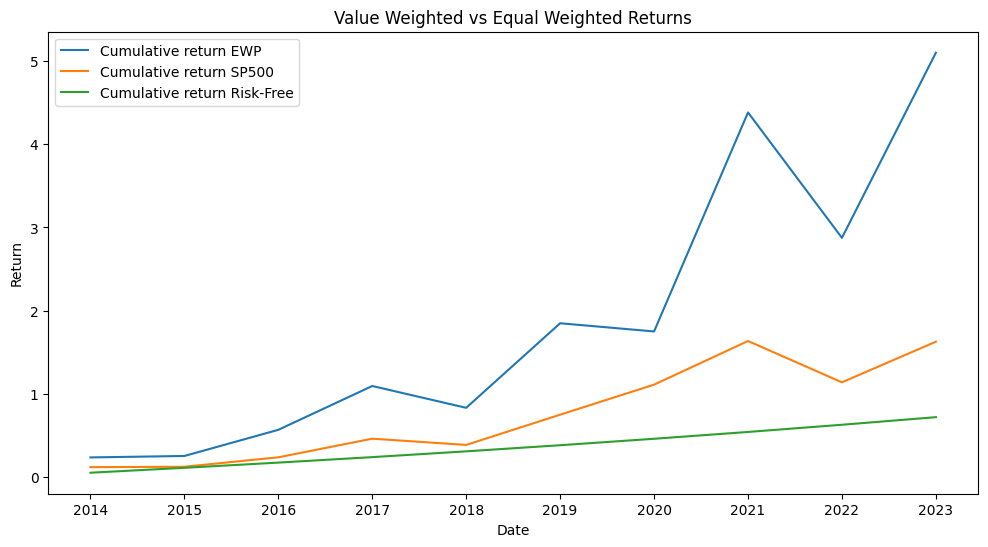

In [39]:
cumulative_returns_EWP = (returns_per_year["Annually_Return_EWP"]+1).cumprod() - 1
cumulative_returns_RiskFree = (returns_per_year["Annually_Return_with_Risk_Free_Asset"]+1).cumprod() - 1
cumulative_returns_SP500 = (returns_per_year["Annually_Return_with_SP500"]+1).cumprod() - 1

plt.figure(figsize=(12, 6))
plt.plot(returns_per_year["Date"], cumulative_returns_EWP, label="Cumulative return EWP")
plt.plot(returns_per_year["Date"], cumulative_returns_SP500, label="Cumulative return SP500")
plt.plot(returns_per_year["Date"], cumulative_returns_RiskFree, label="Cumulative return Risk-Free")

plt.title(f"Value Weighted vs Equal Weighted Returns")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()